## Analyse the performance curve

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import ipdb

In [62]:
models = ['seq2seq', 'hred', 'hred-cf', 'when2talk', 'GatedGCN']
paths = [f'./processed/dailydialog/{i}/conclusion.txt' for i in models]
size = 30

In [63]:
def read_file(path, size=20):
    with open(path) as f:
        bleu4, dist1, dist2, acc, macro, micro = [], [], [], [], [], []
        for line in f.readlines():
            line = line.strip()
            if 'BLEU-4' in line:
                bleu4.append(float(line.replace('BLEU-4: ', '')))
            elif 'Decision Acc' in line:
                acc.append(float(line.replace('Decision Acc: ', '')))
            elif 'F1' in line:
                ma, mi = line.split(',')
                macro.append(float(ma.replace('Decision macro-F1: ', '')))
                micro.append(float(mi.replace('Decision micro-F1: ', '')))
            elif 'Distinct' in line:
                distinct1, distinct2 = line.split(';')
                dist1.append(float(distinct1.replace('Distinct-1: ', '').strip()))
                dist2.append(float(distinct2.replace('Distinct-2: ', '').strip()))
                
    assert len(bleu4) == size
    assert len(dist1) == size
    assert len(dist2) == size
    
    return (bleu4, dist1, dist2, acc, macro, micro)

In [64]:
def draw_curve(ax1, ax2, ax3, ax4, ax5, ax6, 
               bleu4, dist1, dist2, acc, macro, micro, m):
    x = np.arange(1, size + 1)
    
    ax1.plot(x, bleu4, label=m)
    ax1.legend()
    ax1.set_title('BLEU-4')
    
    ax2.plot(x, dist1, label=m)
    ax2.legend()
    ax2.set_title('Distinct-1')
    
    ax3.plot(x, dist2, label=m)
    ax3.legend()
    ax3.set_title('Distinct-2')
    
    if acc:
        ax4.plot(x, acc, label=m)
        ax4.legend()
    ax4.set_title('Acc')
    
    if macro:
        ax5.plot(x, macro, label=m)
        ax5.legend()
    ax5.set_title('Macro-F1')
    
    # if micro:
    #     ax6.plot(x, micro, label=m)
    #     ax6.legend()
    # ax6.set_title('Micro-F1')

In [65]:
def meta_data(bar, data):
    try:
        print(f'{bar}: Max data {np.max(data)}, epoch: {1 + np.argmax(data)}')
    except:
        return 

In [66]:
dataset = []
for m, path in zip(models, paths):
    print(f'========== {m} : {path} ==========')
    data = read_file(path, size=size)
    dataset.append(data)
    meta_data('BLEU-4', data[0])
    meta_data('Dist-1', data[1])
    meta_data('Dist-2', data[2])
    meta_data('Acc', data[3])
    meta_data('Macro-F1', data[4])
    meta_data('Micro-F1', data[5])

========== seq2seq : ./processed/dailydialog/seq2seq/conclusion.txt ==========
BLEU-4: Max data 0.1419, epoch: 28
Dist-1: Max data 0.0367, epoch: 29
Dist-2: Max data 0.248, epoch: 29
========== hred : ./processed/dailydialog/hred/conclusion.txt ==========
BLEU-4: Max data 0.137, epoch: 13
Dist-1: Max data 0.0267, epoch: 30
Dist-2: Max data 0.1827, epoch: 30
========== hred-cf : ./processed/dailydialog/hred-cf/conclusion.txt ==========
BLEU-4: Max data 0.173, epoch: 14
Dist-1: Max data 0.0546, epoch: 27
Dist-2: Max data 0.3623, epoch: 30
Acc: Max data 0.8330275229357799, epoch: 25
Macro-F1: Max data 0.818549375106957, epoch: 25
Micro-F1: Max data 0.8330275229357799, epoch: 25
========== when2talk : ./processed/dailydialog/when2talk/conclusion.txt ==========
BLEU-4: Max data 0.1638, epoch: 11
Dist-1: Max data 0.0511, epoch: 30
Dist-2: Max data 0.3342, epoch: 30
Acc: Max data 0.8271559633027523, epoch: 22
Macro-F1: Max data 0.8201874955746778, epoch: 25
Micro-F1: Max data 0.82715596330275

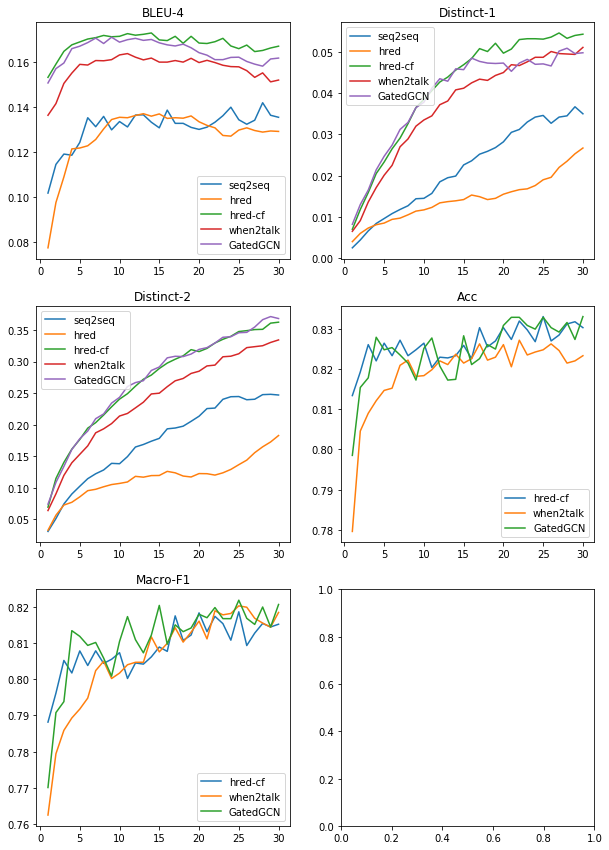

In [67]:
plt.figure(figsize=(10, 20))
sub = [plt.subplot(4, 2, 1), plt.subplot(4, 2, 2), plt.subplot(4, 2, 3),
       plt.subplot(4, 2, 4), plt.subplot(4, 2, 5), plt.subplot(4, 2, 6)]

for d, m in zip(dataset, models):
    draw_curve(*sub, *d, m)